<a href="https://colab.research.google.com/github/Ganeshv2002/Data-Science-Projects/blob/master/FAI_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio geopandas tensorflow folium


In [16]:
!pip install shapely

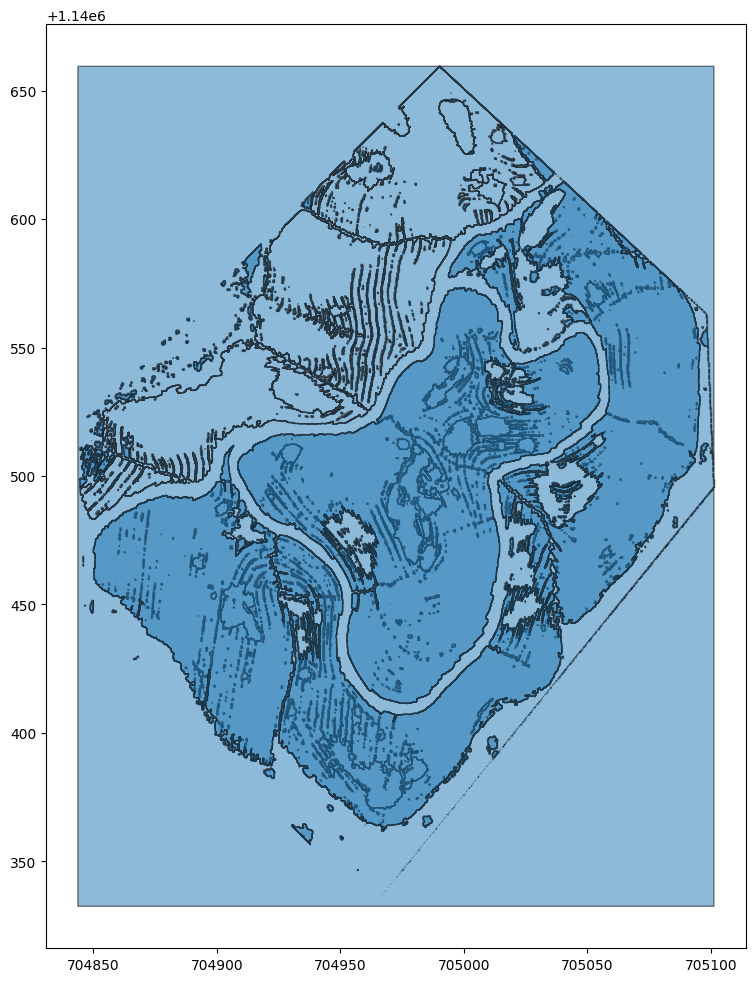

In [23]:
import os
import rasterio
from rasterio.enums import Resampling
import numpy as np
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from rasterio.features import shapes
from shapely.ops import unary_union


base_path = '/content/drive/MyDrive/'
dsm_path = os.path.join(base_path, 'Fai/DSM/SURINOVA_CBE_DSM.tif')
dtm_path = os.path.join(base_path, 'Fai/DTM/SURINOVA_CBE_DTM.tif')
ortho_path = os.path.join(base_path, 'Assesment/SURINOVA_CBE_ORTHO#_stack_raster.tif')


def read_raster(path):
    with rasterio.open(path) as src:
        return src.read(1), src.profile, src.bounds


dsm, dsm_profile, bounds = read_raster(dsm_path)
dtm, dtm_profile, _ = read_raster(dtm_path)


dtm = rasterio.open(dtm_path).read(1, out_shape=dsm.shape, resampling=Resampling.bilinear)


chm = dsm - dtm


vegetation_mask = (chm > 0.5).astype(np.uint8)


def mask_to_polygons(mask, transform):
    results = (
        {'properties': {'raster_val': v}, 'geometry': shape(s)}
        for i, (s, v) in enumerate(
            rasterio.features.shapes(mask, mask=None, transform=transform)))


    gdf = gpd.GeoDataFrame.from_features(results, crs='EPSG:4326')

    return gdf


vegetation_polygons = mask_to_polygons(vegetation_mask, dsm_profile['transform'])


vegetation_polygons = vegetation_polygons.cx[bounds.left:bounds.right, bounds.bottom:bounds.top]


output_vegetation_path = os.path.join(base_path, 'vegetation_polygons_dsm_dtm.shp')
vegetation_polygons.to_file(output_vegetation_path)


fig, ax = plt.subplots(figsize=(12, 12))
vegetation_polygons.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.5)
plt.show()


<ipython-input-24-58649368ae48>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vegetation_polygons['centroid'] = vegetation_polygons['geometry'].centroid
<ipython-input-24-58649368ae48>:8: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_centroids = centroids_gdf.buffer(1.5)
<ipython-input-24-58649368ae48>:32: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


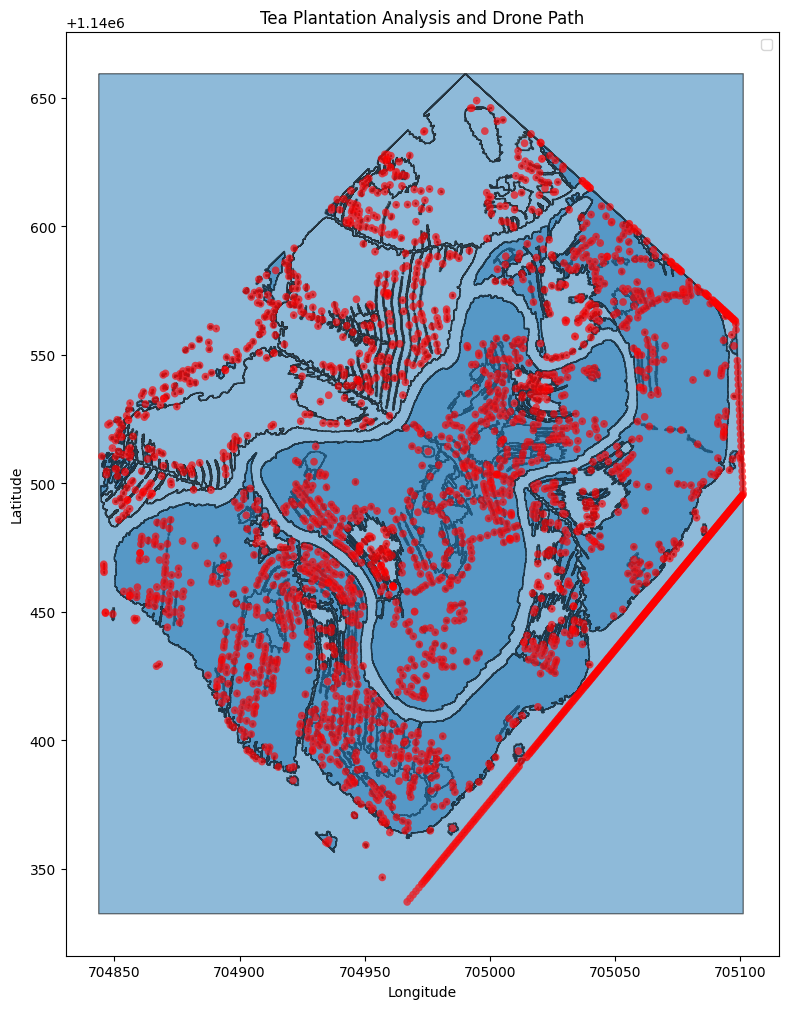

In [24]:
# Get centroids of vegetation polygons
vegetation_polygons['centroid'] = vegetation_polygons['geometry'].centroid

# Create a GeoDataFrame with centroids
centroids_gdf = gpd.GeoDataFrame(geometry=vegetation_polygons['centroid'], crs='EPSG:4326')

# Buffer around centroids with a minimum gap of 1.5 meters
buffered_centroids = centroids_gdf.buffer(1.5)

# Create a GeoDataFrame with buffered centroids
buffered_centroids_gdf = gpd.GeoDataFrame(geometry=buffered_centroids, crs='EPSG:4326')

# Union of buffered centroids to create a single polygon representing the drone path
drone_path_polygon = unary_union(buffered_centroids_gdf['geometry'])

# Convert the drone path polygon to a GeoDataFrame
drone_path_gdf = gpd.GeoDataFrame(geometry=[drone_path_polygon], crs='EPSG:4326')

# Plot the vegetation polygons with the drone path
fig, ax = plt.subplots(figsize=(12, 12))

# Plot vegetation polygons
vegetation_polygons.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.5, label='Vegetation Polygons')

# Plot buffered centroids
buffered_centroids_gdf.plot(ax=ax, color='red', alpha=0.3, label='Buffered Centroids (1.5m Gap)')

# Plot drone path
drone_path_gdf.plot(ax=ax, color='red', alpha=0.5, linewidth=2, label='Drone Path')

# Add legends
ax.legend()

# Add title and labels
plt.title('Tea Plantation Analysis ')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

# Save the drone path as a shapefile
output_drone_path_path = os.path.join(base_path, 'drone_path.shp')
drone_path_gdf.to_file(output_drone_path_path)

<ipython-input-26-8ca5f6a37296>:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


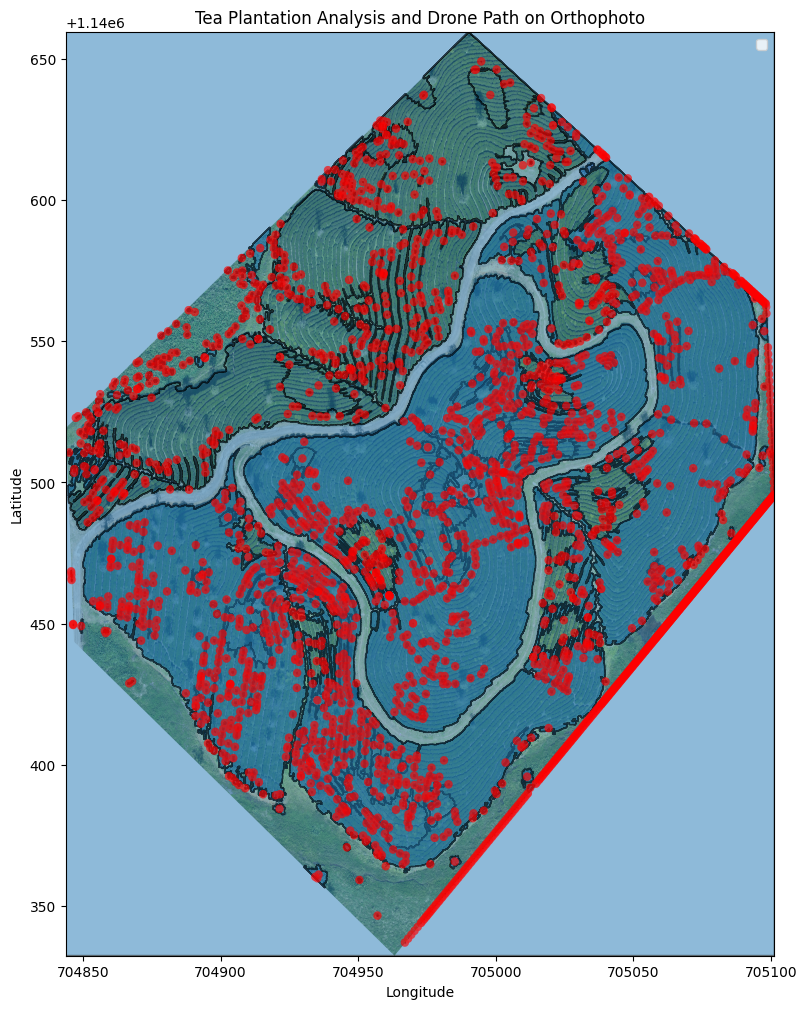

In [26]:
# Read orthophoto
with rasterio.open(ortho_path) as ortho_src:
    ortho = ortho_src.read()

# Get geotransform information from orthophoto
transform = ortho_src.transform

# Plot the vegetation polygons, buffered centroids, and drone path on the orthophoto
fig, ax = plt.subplots(figsize=(12, 12))

# Plot orthophoto as background
ax.imshow(np.transpose(ortho, (1, 2, 0)), extent=[transform[2], transform[2] + transform[0] * ortho.shape[2],
                                                    transform[5] + transform[4] * ortho.shape[1], transform[5]])

# Plot vegetation polygons
vegetation_polygons.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.5, label='Vegetation Polygons')

# Plot buffered centroids
buffered_centroids_gdf.plot(ax=ax, color='red', alpha=0.3, label='Buffered Centroids (1.5m Gap)')

# Plot drone path
drone_path_gdf.plot(ax=ax, color='red', alpha=0.5, linewidth=2, label='Drone Path')

# Add legends
ax.legend()

# Add title and labels
plt.title('Tea Plantation Analysis and Drone Path on Orthophoto')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

# Save the drone path as a shapefile
output_drone_path_path = os.path.join(base_path, 'drone_path.shp')
drone_path_gdf.to_file(output_drone_path_path)